In [1]:
# --- IMPORTAÇÃO DOS DADOS E PRINCIPAIS BIBLIOTECAS ---

from google.colab import files
uploaded = files.upload()

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

df = pd.read_csv('diabetes.csv')

df.sample(5)

Saving diabetes.csv to diabetes.csv


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
99,1,122,90,51,220,49.7,0.325,31,1
357,13,129,0,30,0,39.9,0.569,44,1
547,4,131,68,21,166,33.1,0.160,28,0
235,4,171,72,0,0,43.6,0.479,26,1
709,2,93,64,32,160,38.0,0.674,23,1


In [2]:
# --- VISÃO GERAL E INSPEÇÕES INICIAIS DO DATASET ---

# Informações gerais do DataFrame
print("\n--- VISÃO GERAL DO DATASET ---")
df.info()

# Verificação de registros duplicados
print("\n--- QUANTIDADE DE DUPLICATAS ---")
print(df.duplicated().sum())

# Estatísticas descritivas das variáveis
print("\n--- RESUMO ESTATÍSTICO ---")
print(df.describe())


--- VISÃO GERAL DO DATASET ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB

--- QUANTIDADE DE DUPLICATAS ---
0

--- RESUMO ESTATÍSTICO ---
       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.00

In [3]:
# --- TRATAMENTO DOS TIPOS ---

# Colunas que devem aceitar NaN (zeros serão tratados depois)
col_float = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

# Conversão para float32 (aceita NaN e reduz memória)
df[col_float] = df[col_float].astype('float32')

# Conversão de inteiros para tipos menores
df[["Pregnancies", "Age"]] = df[["Pregnancies", "Age"]].astype("int8")

# Conversão de float64 para float32
df['DiabetesPedigreeFunction'] = df['DiabetesPedigreeFunction'].astype('float32')

# Variável alvo como booleana
df['Outcome'] = df['Outcome'].astype('bool')

print("\n--- TIPOS DOS DADOS APÓS O TRATAMENTO ---")
df.dtypes


--- TIPOS DOS DADOS APÓS O TRATAMENTO ---


,0
Pregnancies,int8
Glucose,float32
BloodPressure,float32
SkinThickness,float32
Insulin,float32
BMI,float32
DiabetesPedigreeFunction,float32
Age,int8
Outcome,bool


In [4]:
# --- TRATAMENTO DE VALORES AUSENTES (ZEROS MASCARADOS) ---

col_nan = [
    'Glucose',
    'BloodPressure',
    'SkinThickness',
    'Insulin',
    'BMI'
]

# Substituição de valores zero por NaN
df[col_nan] = df[col_nan].replace(0, np.nan)

# Resumo após substituição
resumo_substituicao = pd.DataFrame({
    "Valores iguais a zero": (df == 0).sum(),
    "Valores nulos": df.isna().sum()
})

print("\n--- RESUMO APÓS SUBSTITUIÇÃO DE ZEROS POR NaN ---")
print(resumo_substituicao)


--- RESUMO APÓS SUBSTITUIÇÃO DE ZEROS POR NaN ---
                          Valores iguais a zero  Valores nulos
Pregnancies                                 111              0
Glucose                                       0              5
BloodPressure                                 0             35
SkinThickness                                 0            227
Insulin                                       0            374
BMI                                           0             11
DiabetesPedigreeFunction                      0              0
Age                                           0              0
Outcome                                     500              0


In [5]:
# --- IMPUTAÇÃO DE VALORES AUSENTES (MEDIANA) ---

from sklearn.impute import SimpleImputer

# Criação do imputador
imputer_mediana = SimpleImputer(strategy='median')

# Aplicação da imputação nas colunas selecionadas
df[col_nan] = imputer_mediana.fit_transform(df[col_nan])

# Resumo após imputação
resumo_imputacao = pd.DataFrame({
    "Valores iguais a zero": (df == 0).sum(),
    "Valores nulos": df.isna().sum()
})

print("\n--- RESUMO APÓS IMPUTAÇÃO POR MEDIANA ---")
print(resumo_imputacao)


--- RESUMO APÓS IMPUTAÇÃO POR MEDIANA ---
                          Valores iguais a zero  Valores nulos
Pregnancies                                 111              0
Glucose                                       0              0
BloodPressure                                 0              0
SkinThickness                                 0              0
Insulin                                       0              0
BMI                                           0              0
DiabetesPedigreeFunction                      0              0
Age                                           0              0
Outcome                                     500              0


In [6]:
# --- ANÁLISE DE OUTLIERS POR COLUNA (1.5 * IQR) ---

print("\n--- ANÁLISE DE OUTLIERS POR COLUNA (1.5 * IQR) ---")
outliers_iqr = {}

for col in df.columns:
    if pd.api.types.is_numeric_dtype(df[col]) and not pd.api.types.is_bool_dtype(df[col]):
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1

        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR

        mask = (df[col] < lower) | (df[col] > upper)
        outliers_iqr[col] = mask.sum()

outliers_iqr


--- ANÁLISE DE OUTLIERS POR COLUNA (1.5 * IQR) ---


{'Pregnancies': np.int64(4),
 'Glucose': np.int64(0),
 'BloodPressure': np.int64(14),
 'SkinThickness': np.int64(87),
 'Insulin': np.int64(346),
 'BMI': np.int64(8),
 'DiabetesPedigreeFunction': np.int64(29),
 'Age': np.int64(9)}

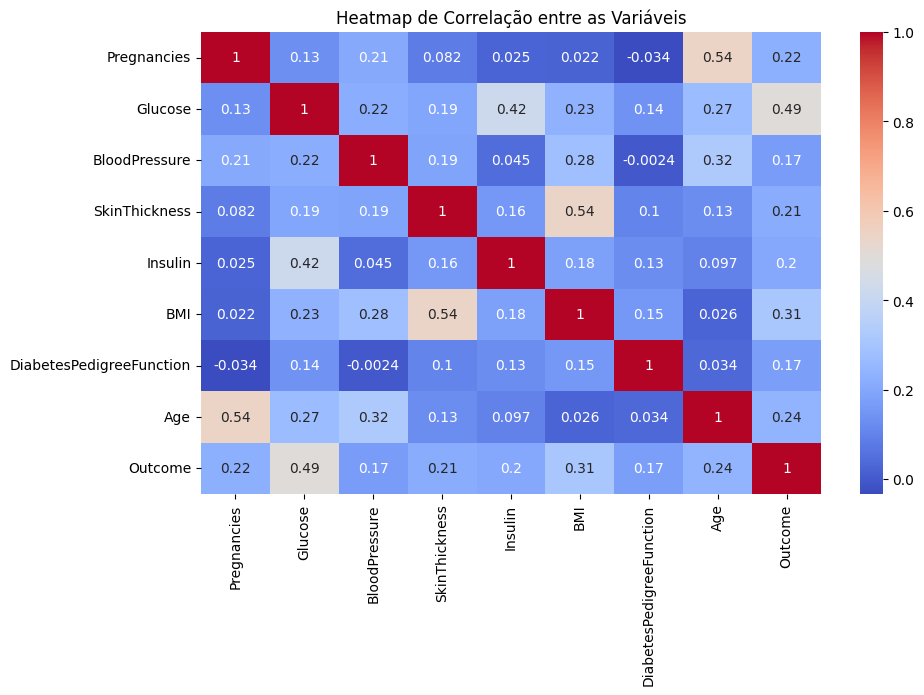

In [7]:
# --- ANÁLISE DE CORRELAÇÃO ENTRE VARIÁVEIS ---

corr_matrix = df.corr()
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm",)
plt.title("Heatmap de Correlação entre as Variáveis")
plt.show()

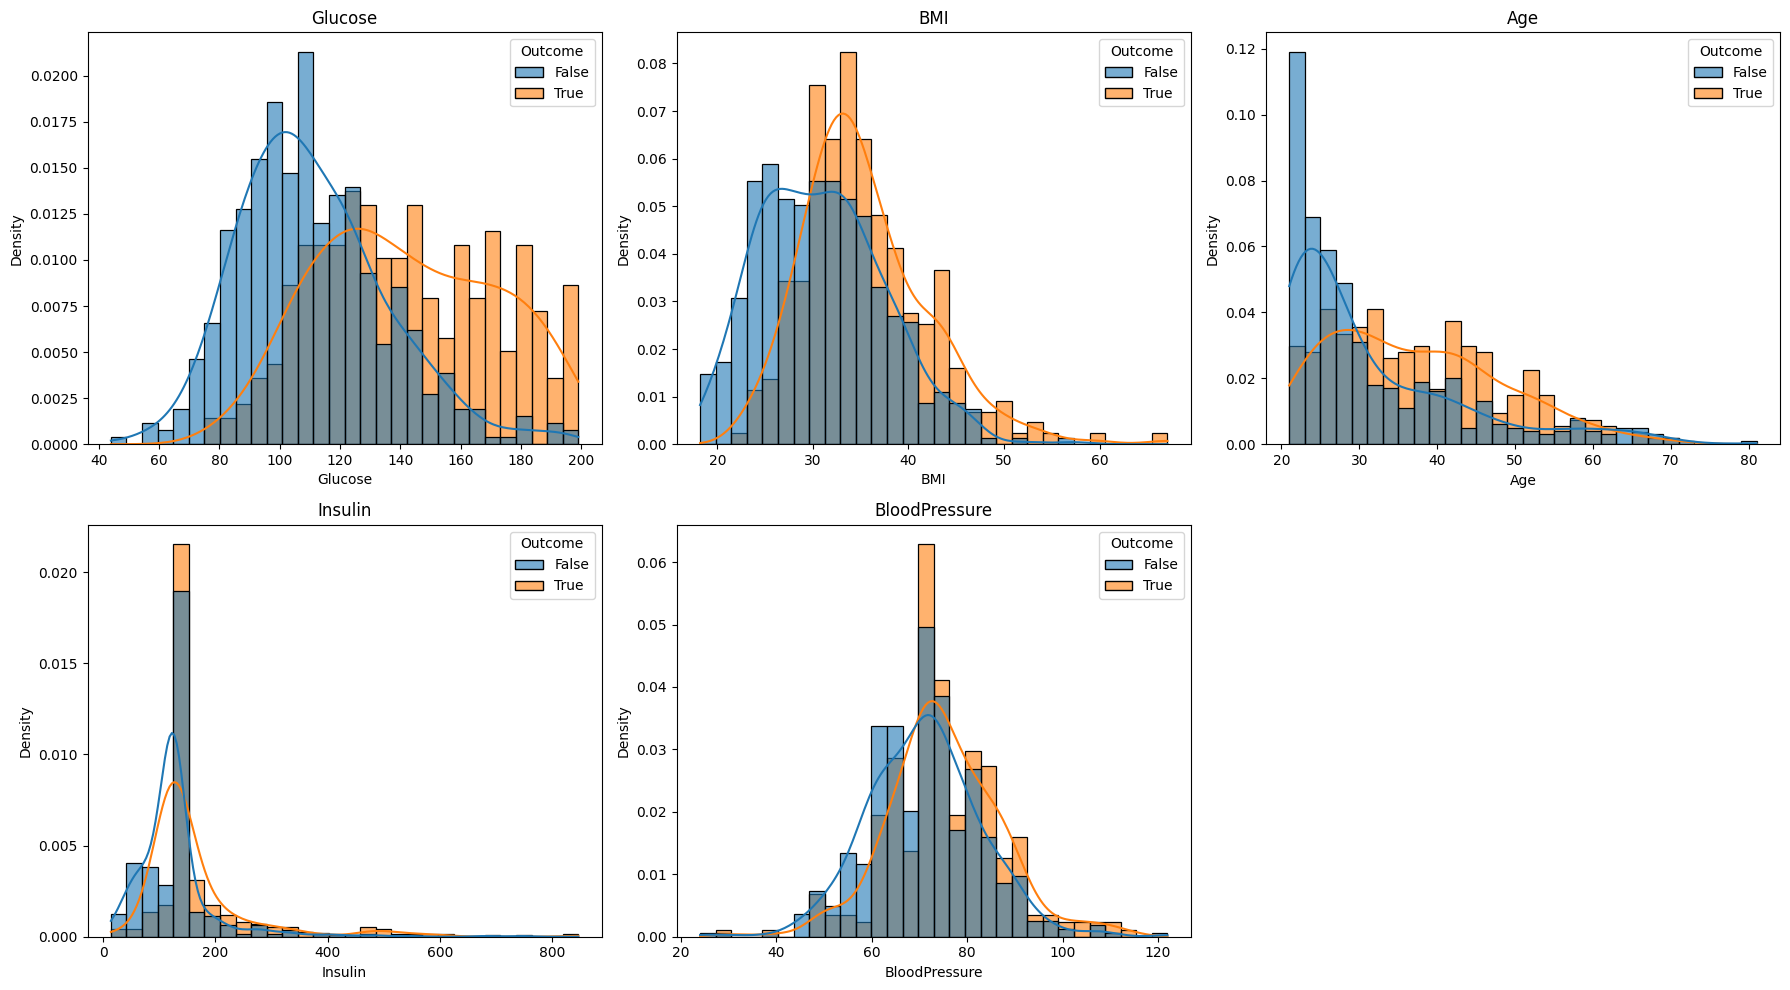

In [8]:
# --- HISTOGRAMAS COMPARATIVOS POR OUTCOME ---

vars = ['Glucose', 'BMI', 'Age', 'Insulin', 'BloodPressure']

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, var in enumerate(vars):
    sns.histplot(data=df, x=var, hue='Outcome', bins=30, kde=True, stat='density', common_norm=False, alpha=0.6, ax=axes[i])
    axes[i].set_title(f'{var}')
    axes[i].set_xlabel(var)

fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()

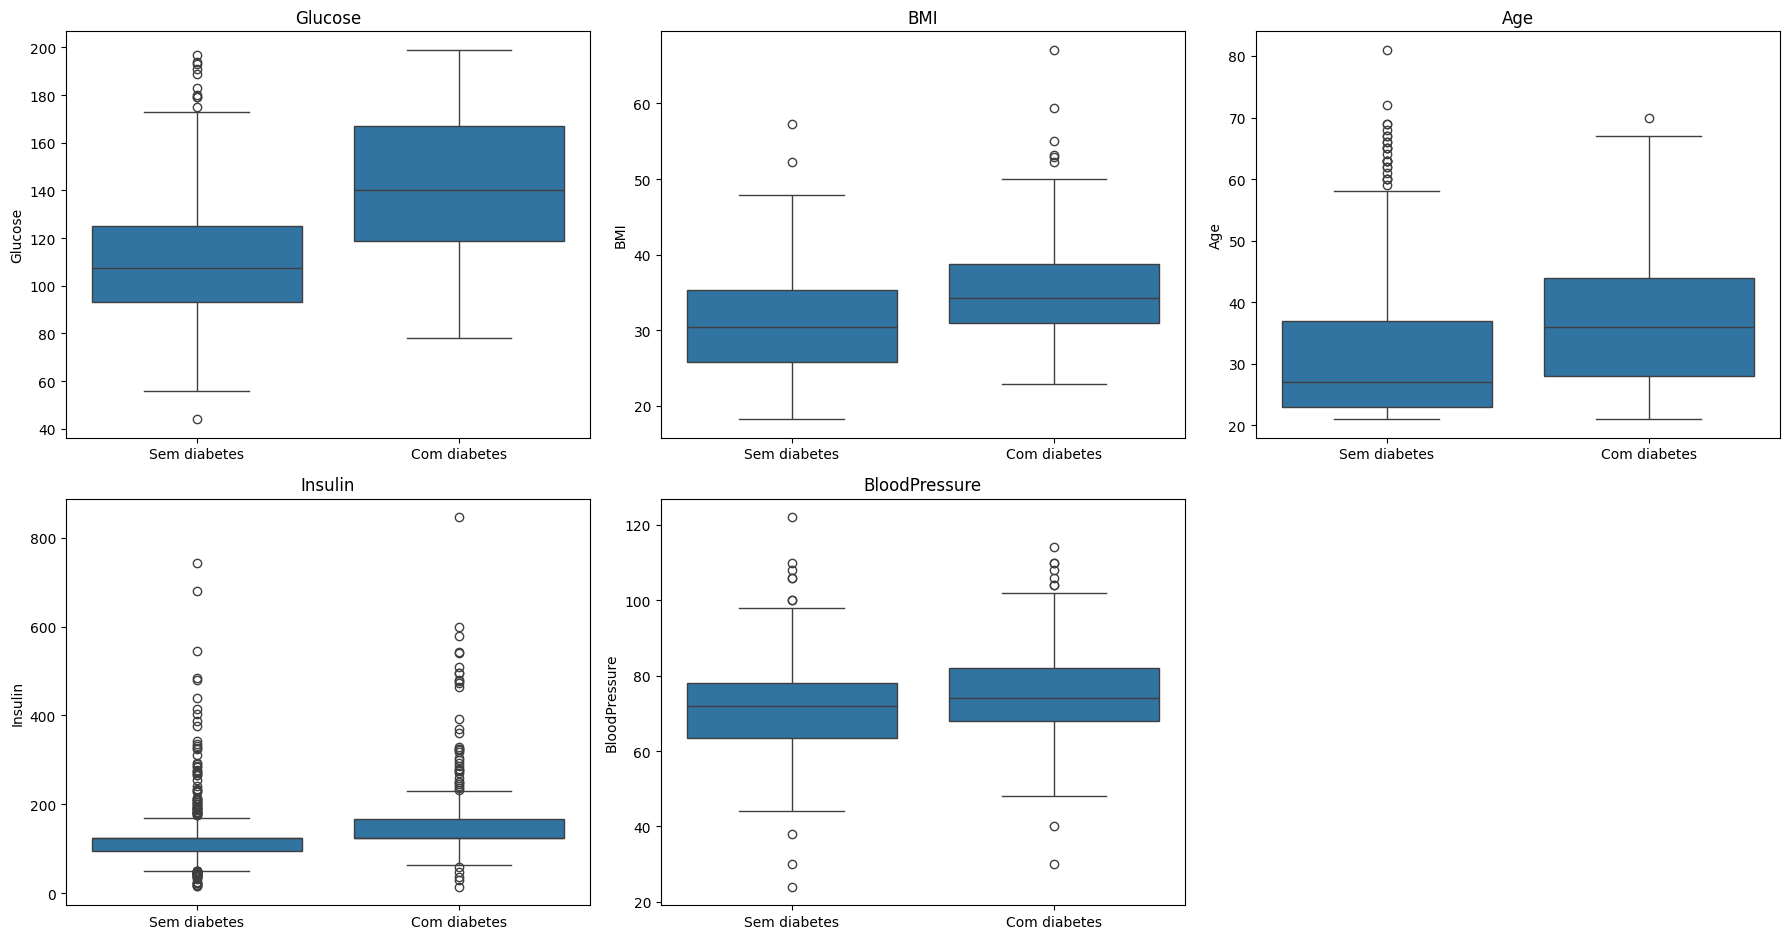

In [9]:
# --- BOXPLOTS COMPARATIVOS POR OUTCOME ---

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, var in enumerate(vars):
    sns.boxplot(data=df, x='Outcome', y=var, ax=axes[i])

    axes[i].set_title(var)
    axes[i].set_xlabel('')
    axes[i].set_xticks([0, 1])
    axes[i].set_xticklabels(['Sem diabetes', 'Com diabetes'])

fig.delaxes(axes[-1])

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [10]:
# --- PRÉ-PROCESSAMENTO PARA MODELAGEM ---

# Separação dos dados (treino e teste):
x = df.drop('Outcome', axis=1)
y = df['Outcome']

x_train, x_test, y_train, y_test = train_test_split(
    x, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# Escalonamento das variáveis:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()

x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [11]:
# --- AVALIAÇÃO DO MODELO BASELINE (REGRESSÃO LOGÍSTICA COM FOCO EM RECALL) ---

from sklearn.linear_model import LogisticRegression

model = LogisticRegression(
    class_weight='balanced',
    random_state=42,
    max_iter=1000)

model.fit(x_train_scaled, y_train)

from sklearn.metrics import recall_score, f1_score, roc_auc_score

y_pred = model.predict(x_test_scaled)
y_proba = model.predict_proba(x_test_scaled)[:, 1]

recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)

# Ajuste de limiar para 0.3:
threshold = 0.3
y_pred_custom = (y_proba >= threshold).astype(int)


print("\n--- AVALIAÇÃO DE MÉTRICAS (REGRESSÃO LOGÍSTICA) ---")

print(f"Recall: {recall:.3f} (limiar 0.5) → {recall_score(y_test, y_pred_custom):.3f} (limiar 0.3)")
print(f"F1-score: {f1:.3f} (limiar 0.5) → {f1_score(y_test, y_pred_custom):.3f} (limiar 0.3)")
print(f"AUC-ROC: {auc:.3f}")


--- AVALIAÇÃO DE MÉTRICAS (REGRESSÃO LOGÍSTICA) ---
Recall: 0.704 (limiar 0.5) → 0.889 (limiar 0.3)
F1-score: 0.650 (limiar 0.5) → 0.676 (limiar 0.3)
AUC-ROC: 0.813


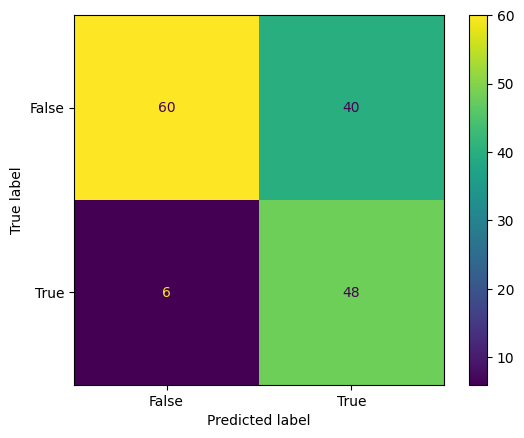

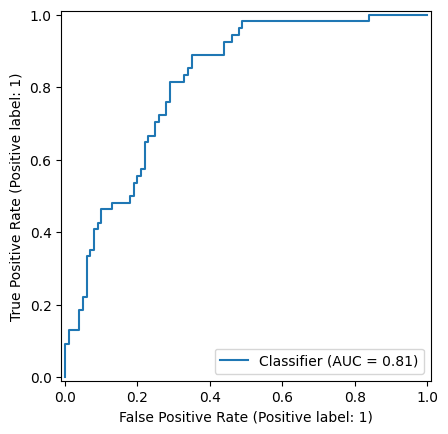

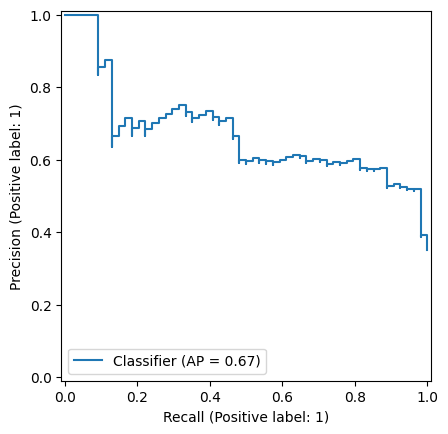

In [12]:
# --- AVALIAÇÃO VISUAL (REGRESSÃO LOGÍSTICA) ---
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_custom);
RocCurveDisplay.from_predictions(y_test, y_proba);
PrecisionRecallDisplay.from_predictions(y_test, y_proba);

In [13]:
# --- AVALIAÇÃO DE MODELO NÃO LINEAR (RANDOM FOREST) ---

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_leaf=5,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

rf.fit(x_train_scaled, y_train)

y_proba_rf = rf.predict_proba(x_test_scaled)[:, 1]
y_pred_rf = (y_proba_rf >= 0.5).astype(int)

# Ajuste de limiar para 0.3:
threshold = 0.3
y_pred_rf_adj = (y_proba_rf >= threshold).astype(int)

print("\n--- AVALIAÇÃO DE MÉTRICAS (RANDOM FOREST) ---")

print(f"Recall: {recall_score(y_test, y_pred_rf)} (limiar 0.5) → {recall_score(y_test, y_pred_rf_adj)} (limiar 0.3)")
print(f"F1-score: {f1_score(y_test, y_pred_rf)} (limiar 0.5) → {f1_score(y_test, y_pred_rf_adj)} (limiar 0.3)")
print("AUC:", roc_auc_score(y_test, y_proba_rf))


--- AVALIAÇÃO DE MÉTRICAS (RANDOM FOREST) ---
Recall: 0.6666666666666666 (limiar 0.5) → 0.8703703703703703 (limiar 0.3)
F1-score: 0.6486486486486487 (limiar 0.5) → 0.6714285714285714 (limiar 0.3)
AUC: 0.8161111111111111


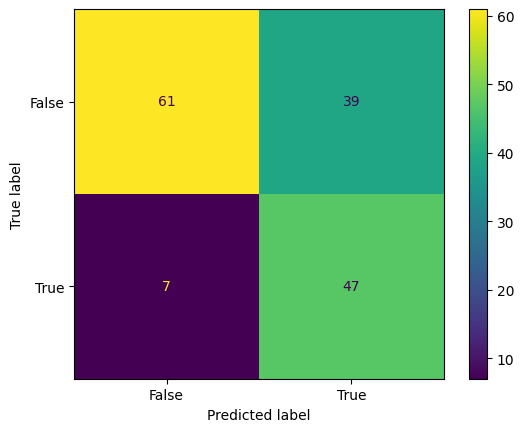

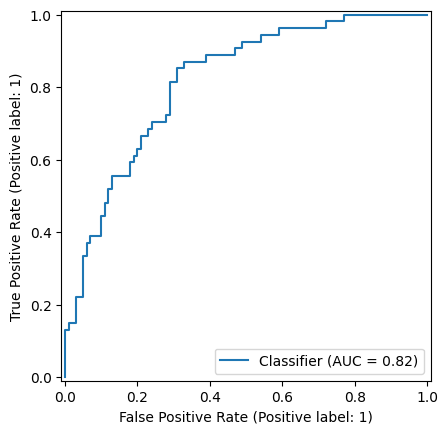

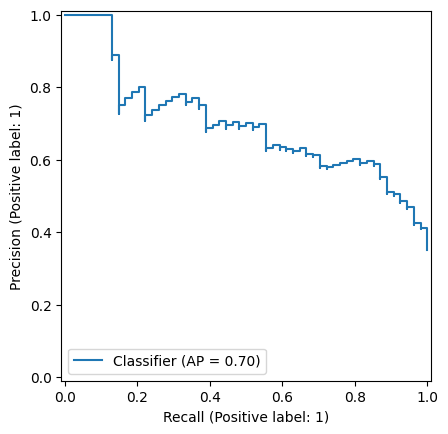

In [14]:
# --- AVALIAÇÃO VISUAL (RANDOM FOREST) ---

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf_adj);
RocCurveDisplay.from_predictions(y_test, y_proba_rf);
PrecisionRecallDisplay.from_predictions(y_test, y_proba_rf);

In [15]:
# --- IMPORTÂNCIA DAS VARIÁVEIS (RANDOM FOREST) ---

pd.Series(rf.feature_importances_, index=x.columns).sort_values(ascending=False)

,0
Glucose,0.333488
BMI,0.172182
Age,0.131240
DiabetesPedigreeFunction,0.099879
Insulin,0.090046
BloodPressure,0.061088
Pregnancies,0.057018
SkinThickness,0.055059
